# 02 - Feature Engineering: Computer Price Prediction

## Simplified and Improved Pipeline

This notebook applies **simplified feature engineering** with:

1. **Data Quality Analysis** - Detect format issues, mixed types, and column groupings
2. **CPU/GPU Parsing** - Extract normalized keys (brand, family, model, suffix)
3. **Benchmark Matching** - Exact matching first, then fuzzy matching with scores
4. **Feature Extraction** - 18 engineered features for modeling

---

## 1. Imports and Setup

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings
from pathlib import Path

# Reload features module
sys.path.append('..')
for mod in ['src.features', 'features']:
    if mod in sys.modules:
        del sys.modules[mod]

from src.features import (
    cargar_datos, construir_features,
    analyze_format_issues, print_column_groups,
    parse_cpu_name, parse_gpu_name,
    prepare_modeling_data, get_feature_columns
)

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)
sns.set_theme(style='whitegrid')
warnings.filterwarnings('ignore')

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 2. Load Raw Data

In [3]:
DATA_DIR = Path('../data')

df_comp, df_cpu, df_gpu = cargar_datos(
    str(DATA_DIR / 'db_computers_2025_raw.csv'),
    str(DATA_DIR / 'db_cpu_raw.csv'),
    str(DATA_DIR / 'db_gpu_raw.csv')
)

print(f"\nDataset shapes:")
print(f"  Computers: {df_comp.shape}")
print(f"  CPU benchmarks: {df_cpu.shape}")
print(f"  GPU benchmarks: {df_gpu.shape}")

Loaded 8,064 computer listings
Loaded 5,138 CPU benchmarks
Loaded 2,692 GPU benchmarks

Dataset shapes:
  Computers: (8064, 135)
  CPU benchmarks: (5138, 5)
  GPU benchmarks: (2692, 5)


## 3. Data Quality Analysis

Detect format issues, mixed types, and column groupings.

In [4]:
# Analyze format issues in each dataset
df_comp_issues = analyze_format_issues(df_comp, "Computers dataset")
df_cpu_issues = analyze_format_issues(df_cpu, "CPU benchmarks")
df_gpu_issues = analyze_format_issues(df_gpu, "GPU benchmarks")


Analyzing: Computers dataset
------------------------------------------------------------

Analyzing: CPU benchmarks
------------------------------------------------------------

Analyzing: GPU benchmarks
------------------------------------------------------------


In [5]:
# Show columns with format issues
print("\n=== Computers: Columns with mixed types ===")
mixed_cols = df_comp_issues[df_comp_issues['mixed_numeric_text'] == True]
if len(mixed_cols) > 0:
    display(mixed_cols[['column', 'sample_text_values']].head(10))
else:
    print("No mixed type columns detected")

print("\n=== Computers: Columns with multilabel values ===")
multilabel = df_comp_issues[df_comp_issues['multilabel_rows'] > 100].sort_values('multilabel_rows', ascending=False)
if len(multilabel) > 0:
    display(multilabel[['column', 'multilabel_rows']].head(10))
else:
    print("No significant multilabel columns")


=== Computers: Columns with mixed types ===


,column,sample_text_values
0,Título,"[Apple MacBook Air 13"" 2024 M3, Apple MacBook ..."
1,Precio_Rango,"[1.026,53 € – 2.287,17 €, 1.270,42 € – 2.672,2..."
2,Ofertas,"[200 ofertas:, 230 ofertas:, 136 ofertas:, 30 ..."
3,Tipo de producto,"[Portátil multimedia, Portátil multimedia, Por..."
4,Serie,"[Apple MacBook Air, Apple MacBook Air, Apple M..."
5,Pantalla_Tamaño de la pantalla,"[13,6 pulgadas, 15,3 pulgadas, 14,2 pulgadas, ..."
6,Pantalla_Diagonal de la pantalla,"[34,544 cm, 38,862 cm, 36,068 cm, 39,624 cm, 4..."
7,Pantalla_Tecnología de la pantalla,"[Retina, Retina, Retina, Full HD, UHD+]"
8,Pantalla_Luminosidad,"[500 cd/m², 500 cd/m², 1.000 cd/m², 600 cd/m²,..."
9,Procesador_Procesador,"[Apple M3, Apple M3, Intel Core i7-13700H, Int..."



=== Computers: Columns with multilabel values ===


,column,multilabel_rows
1,Precio_Rango,7927
14,Comunicaciones_Conectividad,5684
30,Medidas y peso_Profundidad,5442
32,Medidas y peso_Ancho,5381
65,Procesador_Frecuencia turbo máx.,5256
33,Medidas y peso_Peso,4715
34,Otras características_Equipamiento,4282
6,Pantalla_Diagonal de la pantalla,4019
64,Procesador_Frecuencia de reloj,2774
114,Procesador_Frecuencia del reloj,2512


In [6]:
# Show column groups by prefix
print_column_groups(df_comp)


=== Column Groups by Prefix ===

GROUP: Alimentación
   - Alimentación_Batería
   - Alimentación_Autonomía de la batería
   - Alimentación_Vatios-hora
   - Alimentación_Alimentación
   - Alimentación_Batería intercambiable
   - Alimentación_Número de celdas
   - Alimentación_Voltaje de salida
   - Alimentación_Intensidad de corriente
   - Alimentación_Capacidad de la batería

GROUP: Almacenamiento
   - Almacenamiento_Lector óptico
   - Almacenamiento_Velocidades de lectura
   - Almacenamiento_Velocidades de escritura
   - Almacenamiento_Formato audiovisual compatible

GROUP: Comunicaciones
   - Comunicaciones_Conectividad
   - Comunicaciones_Versión Bluetooth
   - Comunicaciones_Estándar wifi
   - Comunicaciones_Transmisión de datos
   - Comunicaciones_Estándar LAN
   - Comunicaciones_Características del Bluetooth

GROUP: Conectividad
   - Conectividad_Lector de tarjetas
   - Conectividad_Tipo de tarjetas compatibles
   - Conectividad_Conexión
   - Conectividad_Conexión frontal

GROUP

## 4. CPU/GPU Parsing Preview

Test the parsing logic on sample data before running full feature engineering.

In [7]:
# Test CPU parsing on sample data
print("=== CPU Parsing Examples ===")
cpu_samples = df_comp['Procesador_Procesador'].dropna().sample(10, random_state=42)

for cpu in cpu_samples:
    parsed = parse_cpu_name(cpu)
    print(f"\nOriginal: {cpu}")
    print(f"  -> Key: {parsed['cpu_normalized_key']}")
    print(f"  -> Brand: {parsed['cpu_brand']}, Family: {parsed['cpu_family']}")
    print(f"  -> Model: {parsed['cpu_model_code']}, Suffix: {parsed['cpu_suffix']}")

=== CPU Parsing Examples ===

Original: Intel Core i5-12400
  -> Key: intel core i5 12400
  -> Brand: intel, Family: core i5
  -> Model: 12400, Suffix: None

Original: Inter Core i7-12700
  -> Key: intel core i7 12700
  -> Brand: intel, Family: core i7
  -> Model: 12700, Suffix: None

Original: Intel Core i7-13700F
  -> Key: intel core i7 13700f
  -> Brand: intel, Family: core i7
  -> Model: 13700f, Suffix: None

Original: Intel Core i5-13400F
  -> Key: intel core i5 13400f
  -> Brand: intel, Family: core i5
  -> Model: 13400f, Suffix: None

Original: AMD Ryzen 3 3200G
  -> Key: amd ryzen 3 3200g
  -> Brand: amd, Family: ryzen 3
  -> Model: 3200g, Suffix: None

Original: AMD Ryzen 7 7735HS
  -> Key: amd ryzen 7 7735hs
  -> Brand: amd, Family: ryzen 7
  -> Model: 7735hs, Suffix: None

Original: Intel Core i5-10400
  -> Key: intel core i5 10400
  -> Brand: intel, Family: core i5
  -> Model: 10400, Suffix: None

Original: AMD Ryzen 5 7500F
  -> Key: amd ryzen 5 7500f
  -> Brand: amd, Fami

In [8]:
# Test GPU parsing on sample data
print("=== GPU Parsing Examples ===")
gpu_samples = df_comp['Gráfica_Tarjeta gráfica'].dropna().sample(10, random_state=21)

for gpu in gpu_samples:
    parsed = parse_gpu_name(gpu)
    print(f"\nOriginal: {gpu}")
    print(f"  -> Key: {parsed['gpu_normalized_key']}")
    print(f"  -> Brand: {parsed['gpu_brand']}, Series: {parsed['gpu_series']}")
    print(f"  -> Model: {parsed['gpu_model_number']}, Integrated: {parsed['gpu_is_integrated']}")

=== GPU Parsing Examples ===

Original: NVIDIA GeForce RTX 4070
  -> Key: nvidia rtx 4070
  -> Brand: nvidia, Series: rtx
  -> Model: 4070, Integrated: False

Original: NVIDIA GeForce RTX 4050
  -> Key: nvidia rtx 4050
  -> Brand: nvidia, Series: rtx
  -> Model: 4050, Integrated: False

Original: AMD Radeon 610M
  -> Key: amd
  -> Brand: amd, Series: None
  -> Model: None, Integrated: False

Original: AMD Radeon RX 7900 GRE
  -> Key: amd rx 7900
  -> Brand: amd, Series: rx
  -> Model: 7900, Integrated: False

Original: AMD Radeon RX Vega 8
  -> Key: amd vega 8
  -> Brand: amd, Series: vega
  -> Model: 8, Integrated: False

Original: Intel Iris Xe Graphics
  -> Key: intel iris xe
  -> Brand: intel, Series: iris
  -> Model: xe, Integrated: True

Original: NVIDIA GeForce RTX 4090
  -> Key: nvidia rtx 4090
  -> Brand: nvidia, Series: rtx
  -> Model: 4090, Integrated: False

Original: Intel UHD Graphics
  -> Key: intel
  -> Brand: intel, Series: None
  -> Model: None, Integrated: True

Orig

## 5. Run Feature Engineering

In [9]:
# Build all engineered features
print("="*80)
print("RUNNING FEATURE ENGINEERING")
print("="*80)
print(f"\nProcessing {len(df_comp):,} computer listings...\n")

df_feat = construir_features(df_comp, df_cpu, df_gpu)

print(f"\nDataframe shape: {df_feat.shape}")

RUNNING FEATURE ENGINEERING

Processing 8,064 computer listings...


FEATURE ENGINEERING

1. Extracting _precio_num...
   Valid prices: 7,927

2. Extracting _brand...
   Brands: 89 unique

3. Extracting _serie...
   Series: 5,299

4. Extracting _ram_gb...
   RAM: 6,749

5. Extracting _ssd_gb...
   SSD: 6,656

6. Extracting _tamano_pantalla_pulgadas...
   Screen size: 4,025

7. Extracting _cpu_cores...
   CPU cores: 6,498

8. Matching CPU benchmarks...
Parsing CPU names...
Building CPU lookup table...
Performing exact CPU matches...
  Exact matches: 85.1%
Performing fuzzy CPU matches...
Performing close neighbor CPU matches...
  Neighbor matches: 0
Computing family mean for remaining unmatched CPUs...
  Family mean imputations: 0
  Brand mean imputations: 0

CPU match strategy distribution:
exact        6862
unmatched    1115
fuzzy          87
Name: cpu_match_strategy, dtype: int64

CPU benchmark coverage: 86.2%
   CPU mark: 6,949
   CPU rank: 6,949
   CPU value: 5,371
   CPU price: 5,3

In [10]:
# List all engineered features
engineered = sorted([c for c in df_feat.columns if c.startswith('_')])
print(f"\nTotal engineered features: {len(engineered)}\n")

for i, feat in enumerate(engineered, 1):
    non_null = df_feat[feat].notna().sum()
    pct = non_null / len(df_feat) * 100
    print(f"{i:2d}. {feat:35s}: {non_null:5,}/{len(df_feat):,} ({pct:5.1f}%)")


Total engineered features: 23

 1. _brand                             : 8,064/8,064 (100.0%)
 2. _cpu_cores                         : 6,498/8,064 ( 80.6%)
 3. _cpu_mark                          : 6,949/8,064 ( 86.2%)
 4. _cpu_price_usd                     : 5,371/8,064 ( 66.6%)
 5. _cpu_rank                          : 6,949/8,064 ( 86.2%)
 6. _cpu_value                         : 5,371/8,064 ( 66.6%)
 7. _gpu_mark                          : 6,641/8,064 ( 82.4%)
 8. _gpu_memory_gb                     : 2,573/8,064 ( 31.9%)
 9. _gpu_price_usd                     : 3,658/8,064 ( 45.4%)
10. _gpu_rank                          : 6,641/8,064 ( 82.4%)
11. _gpu_value                         : 3,658/8,064 ( 45.4%)
12. _peso_kg                           : 5,003/8,064 ( 62.0%)
13. _precio_num                        : 7,927/8,064 ( 98.3%)
14. _ram_gb                            : 6,749/8,064 ( 83.7%)
15. _resolucion_pixeles                : 3,335/8,064 ( 41.4%)
16. _serie                            

## 6. CPU/GPU Matching Analysis

In [11]:
# CPU matching summary
print("=" * 60)
print("CPU BENCHMARK MATCHING")
print("=" * 60)

print("\nMatch strategy distribution:")
print(df_feat['cpu_match_strategy'].value_counts(dropna=False))

# Coverage by brand
print("\nCoverage by CPU brand:")
for brand in ['intel', 'amd', 'apple', 'qualcomm']:
    mask = df_feat['cpu_brand'] == brand
    if mask.sum() > 0:
        matched = df_feat.loc[mask, 'cpu_bench_mark'].notna().sum()
        total = mask.sum()
        print(f"  {brand.capitalize():10s}: {matched:4,}/{total:4,} ({matched/total*100:5.1f}%)")

CPU BENCHMARK MATCHING

Match strategy distribution:
exact        6862
unmatched    1115
fuzzy          87
Name: cpu_match_strategy, dtype: int64

Coverage by CPU brand:
  Intel     : 5,170/5,170 (100.0%)
  Amd       : 1,467/1,467 (100.0%)
  Apple     :  244/ 244 (100.0%)
  Qualcomm  :   63/  63 (100.0%)


In [12]:
# GPU matching summary
print("=" * 60)
print("GPU BENCHMARK MATCHING")
print("=" * 60)

print("\nMatch strategy distribution:")
print(df_feat['gpu_match_strategy'].value_counts(dropna=False))

# Show discrete GPU coverage
discrete_mask = df_feat['gpu_is_integrated'] != True
if discrete_mask.sum() > 0:
    matched = df_feat.loc[discrete_mask, 'gpu_bench_mark'].notna().sum()
    total = discrete_mask.sum()
    print(f"\nDiscrete GPU coverage: {matched:,}/{total:,} ({matched/total*100:.1f}%)")

GPU BENCHMARK MATCHING

Match strategy distribution:
integrated    3493
exact         3050
unmatched     1372
fuzzy          149
Name: gpu_match_strategy, dtype: int64

Discrete GPU coverage: 3,199/4,571 (70.0%)


In [13]:
# Show sample matched CPUs
print("\n=== Sample Matched CPUs ===")
matched_cpus = df_feat[df_feat['cpu_match_strategy'].isin(['exact', 'fuzzy'])][
    ['Procesador_Procesador', 'cpu_normalized_key', 'cpu_bench_name', 
     'cpu_bench_mark', 'cpu_match_strategy', 'cpu_match_score']
].head(15)
display(matched_cpus)


=== Sample Matched CPUs ===


,Procesador_Procesador,cpu_normalized_key,cpu_bench_name,cpu_bench_mark,cpu_match_strategy,cpu_match_score
0,Apple M3,apple m3,Apple M3 Max 16 Core,41228.00,exact,1.00
1,Apple M3,apple m3,Apple M3 Max 16 Core,41228.00,exact,1.00
4,Intel Core i7-13700H,intel core i7 13700h,Intel Core i7-13700H,26452.00,exact,1.00
5,Intel Core Ultra 7 155H,intel core ultra 7 155h,Intel Core Ultra 7 155H,24954.00,exact,1.00
6,AMD Ryzen AI 9 HX 370,amd ryzen 9 370 hx,AMD Ryzen AI 9 HX 370,35129.00,exact,1.00
7,Intel Core Ultra 9 185H,intel core ultra 9 185h,Intel Core Ultra 9 185H,29409.00,exact,1.00
8,AMD Ryzen 7 8840HS,amd ryzen 7 8840hs,AMD Ryzen 7 PRO 8840HS,27059.00,exact,1.00
18,Intel Core i7-13620H,intel core i7 13620h,Intel Core i7-13620H,24274.00,exact,1.00
21,AMD Ryzen 7 8840HS,amd ryzen 7 8840hs,AMD Ryzen 7 PRO 8840HS,27059.00,exact,1.00
23,Apple M3,apple m3,Apple M3 Max 16 Core,41228.00,exact,1.00


In [14]:
# Show sample matched GPUs
print("\n=== Sample Matched GPUs ===")
matched_gpus = df_feat[df_feat['gpu_match_strategy'].isin(['exact', 'fuzzy'])][
    ['Gráfica_Tarjeta gráfica', 'gpu_normalized_key', 'gpu_bench_name', 
     'gpu_bench_mark', 'gpu_match_strategy', 'gpu_match_score']
].head(15)
display(matched_gpus)


=== Sample Matched GPUs ===


,Gráfica_Tarjeta gráfica,gpu_normalized_key,gpu_bench_name,gpu_bench_mark,gpu_match_strategy,gpu_match_score
18,NVIDIA GeForce RTX 4070,nvidia rtx 4070,GeForce RTX 4070,26941.00,exact,1.00
25,NVIDIA GeForce RTX 3050,nvidia rtx 3050,GeForce RTX 3050 8GB,12580.00,exact,1.00
26,NVIDIA GeForce RTX 4070,nvidia rtx 4070,GeForce RTX 4070,26941.00,exact,1.00
40,AMD Radeon 610M,amd,Radeon 8060S,17350.00,exact,1.00
41,NVIDIA GeForce RTX 4060,nvidia rtx 4060,GeForce RTX 4060,19703.00,exact,1.00
55,NVIDIA GeForce RTX 4050,nvidia rtx 4050,RTX 4500 Ada Generation,27468.00,fuzzy,0.93
62,NVIDIA GeForce RTX 4070,nvidia rtx 4070,GeForce RTX 4070,26941.00,exact,1.00
63,NVIDIA GeForce RTX 4070,nvidia rtx 4070,GeForce RTX 4070,26941.00,exact,1.00
71,AMD Radeon RX Vega,amd,Radeon 8060S,17350.00,exact,1.00
74,NVIDIA GeForce RTX 4060,nvidia rtx 4060,GeForce RTX 4060,19703.00,exact,1.00


## 7. Feature Correlation Analysis

Analyze correlations between engineered features and price to validate feature engineering.

In [15]:
# Correlation with price
numeric_feats = [
    '_ram_gb', '_ssd_gb', '_cpu_cores', '_gpu_memory_gb',
    # CPU benchmark features
    '_cpu_mark', '_cpu_rank', '_cpu_value', '_cpu_price_usd',
    # GPU benchmark features
    '_gpu_mark', '_gpu_rank', '_gpu_value', '_gpu_price_usd',
    # Other features
    '_tamano_pantalla_pulgadas', '_resolucion_pixeles', 
    '_tasa_refresco_hz', '_peso_kg', '_precio_num'
]

available = [f for f in numeric_feats if f in df_feat.columns]
corr = df_feat[available].corr()['_precio_num'].drop('_precio_num').sort_values(ascending=False)

print("=" * 60)
print("CORRELATION WITH PRICE")
print("=" * 60)
print(f"\n{'Feature':<35s} {'Correlation':>12s} {'Strength':>12s}")
print("-" * 60)

for feat, c in corr.items():
    if pd.notna(c):
        strength = "Strong" if abs(c) >= 0.5 else "Moderate" if abs(c) >= 0.3 else "Weak"
        print(f"{feat:<35s} {c:>12.3f} {strength:>12s}")

CORRELATION WITH PRICE

Feature                              Correlation     Strength
------------------------------------------------------------
_ram_gb                                    0.598       Strong
_cpu_mark                                  0.563       Strong
_cpu_cores                                 0.544       Strong
_cpu_price_usd                             0.532       Strong
_resolucion_pixeles                        0.489     Moderate
_gpu_price_usd                             0.468     Moderate
_ssd_gb                                    0.463     Moderate
_tasa_refresco_hz                          0.455     Moderate
_gpu_mark                                  0.435     Moderate
_gpu_memory_gb                             0.311     Moderate
_tamano_pantalla_pulgadas                  0.190         Weak
_peso_kg                                   0.141         Weak
_cpu_value                                 0.022         Weak
_gpu_rank                                 -0.27

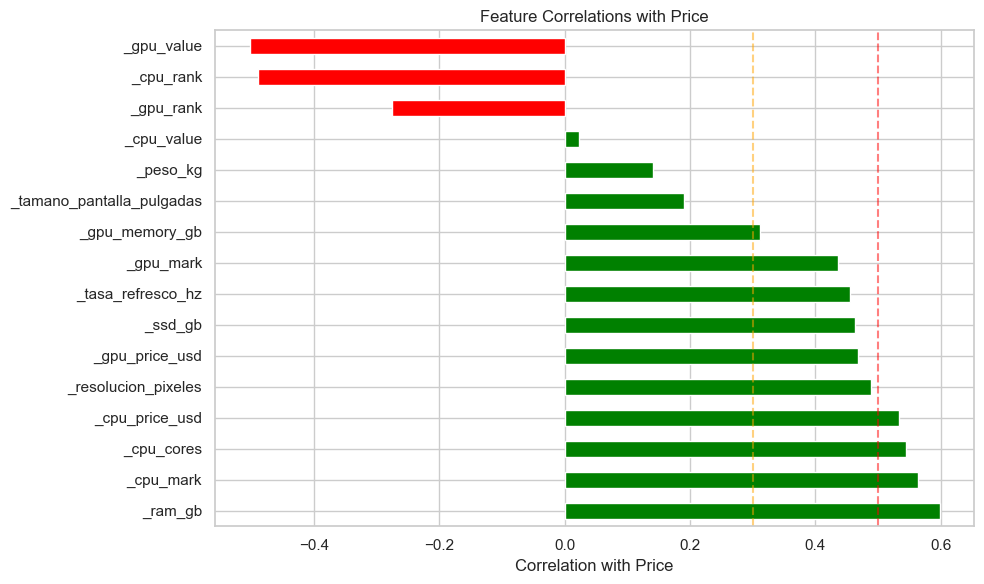

In [16]:
# Visualize correlations
fig, ax = plt.subplots(figsize=(10, 6))
corr.plot(kind='barh', ax=ax, color=['green' if x > 0 else 'red' for x in corr])
ax.set_xlabel('Correlation with Price')
ax.set_title('Feature Correlations with Price')
ax.axvline(0.3, color='orange', linestyle='--', alpha=0.5)
ax.axvline(0.5, color='red', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## 8. Engineered Feature Distributions

Visualize distributions of key engineered features to check for anomalies.

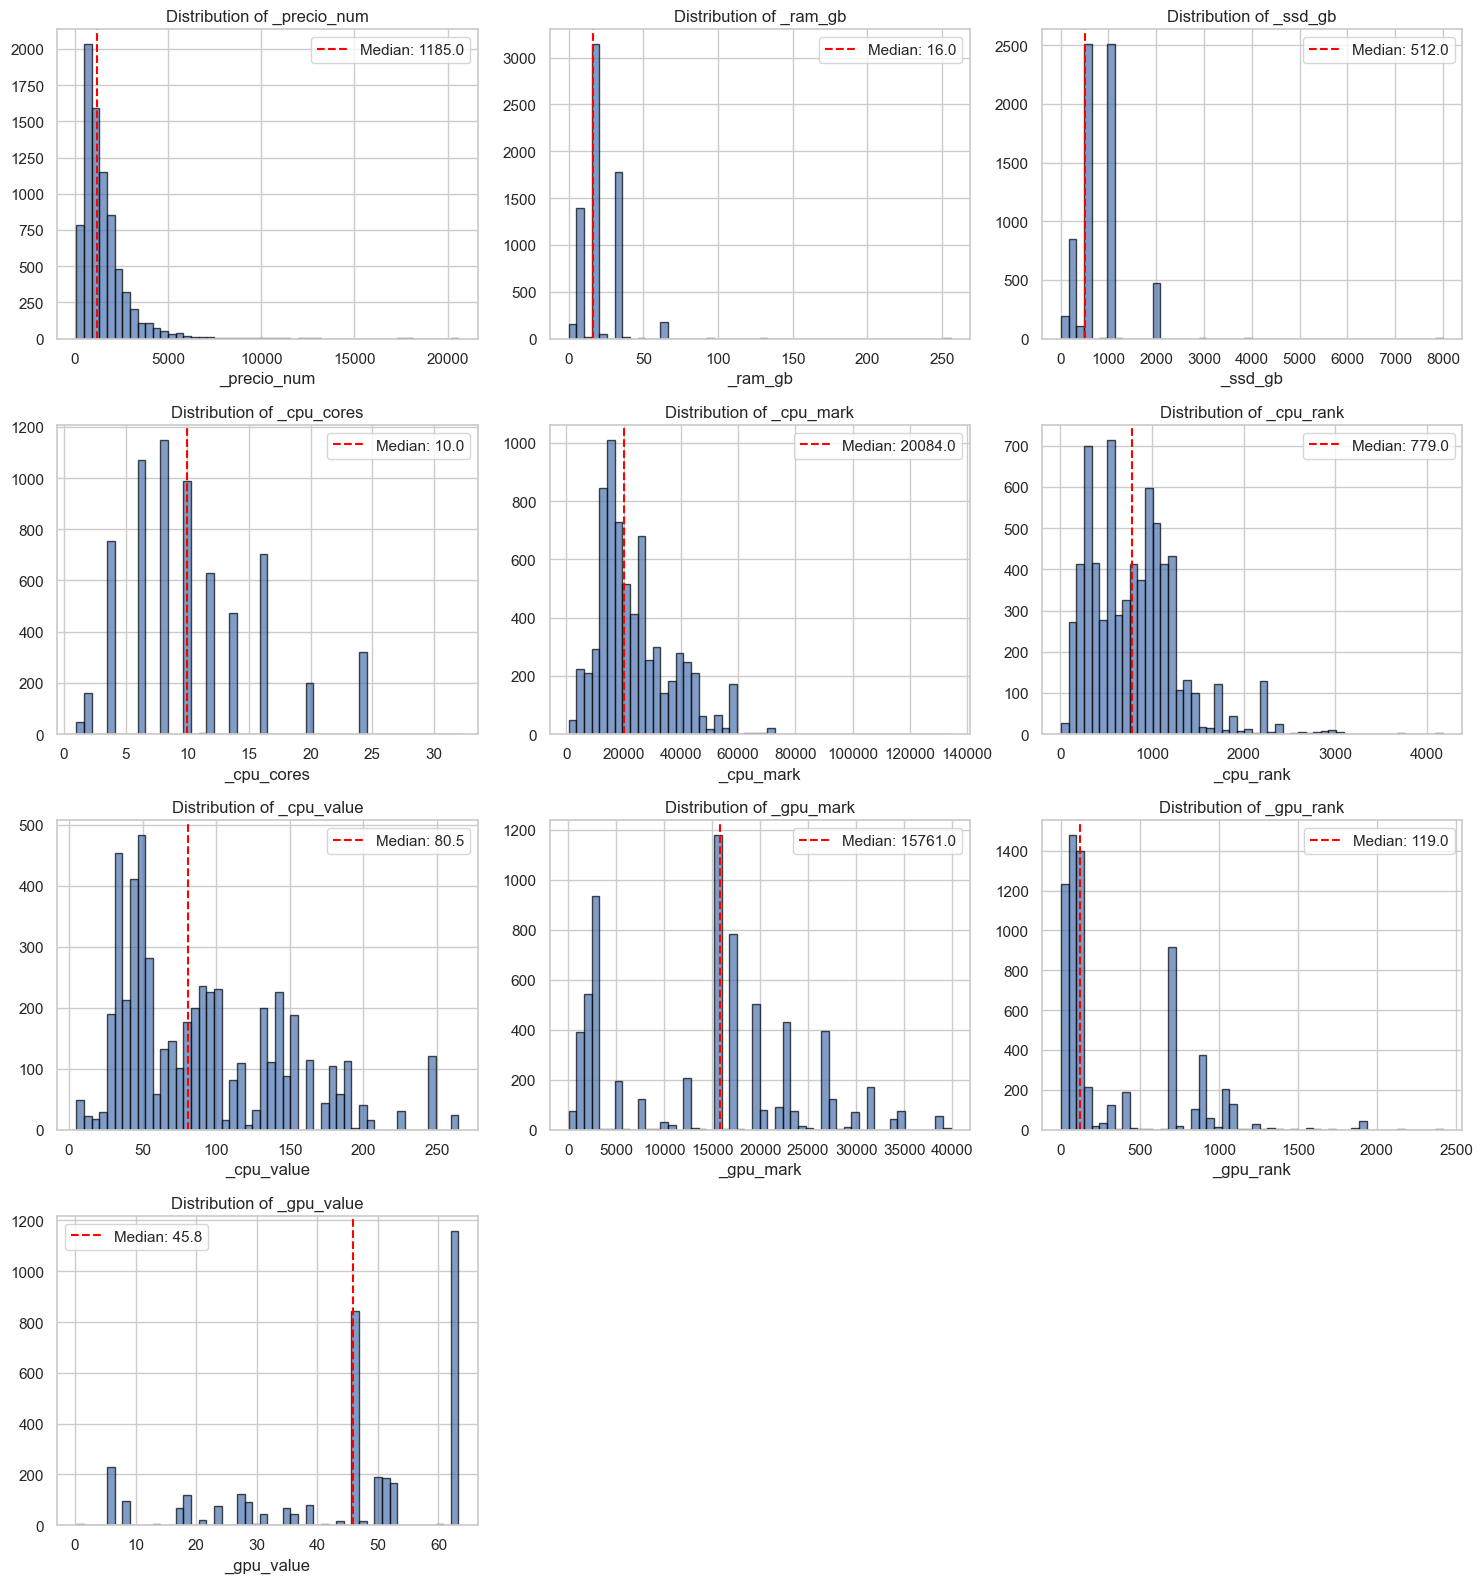

In [17]:
# Plot distributions of key features (including new benchmark features)
key_feats = [
    '_precio_num', '_ram_gb', '_ssd_gb', '_cpu_cores', 
    '_cpu_mark', '_cpu_rank', '_cpu_value',
    '_gpu_mark', '_gpu_rank', '_gpu_value'
]
key_feats = [f for f in key_feats if f in df_feat.columns]

n_cols = 3
n_rows = (len(key_feats) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.ravel()

for idx, feat in enumerate(key_feats):
    if idx < len(axes):
        data = df_feat[feat].dropna()
        if len(data) > 0:
            axes[idx].hist(data, bins=50, edgecolor='black', alpha=0.7)
            axes[idx].set_xlabel(feat)
            axes[idx].set_title(f'Distribution of {feat}')
            axes[idx].axvline(data.median(), color='red', linestyle='--', 
                             label=f'Median: {data.median():.1f}')
            axes[idx].legend()

# Hide unused subplots
for idx in range(len(key_feats), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

## 9. Missing Values Summary

In [18]:
# Missing values for engineered features
eng_feats = [c for c in df_feat.columns if c.startswith('_')]
missing = pd.DataFrame({
    'Missing': df_feat[eng_feats].isna().sum(),
    'Missing %': (df_feat[eng_feats].isna().sum() / len(df_feat) * 100).round(1)
}).sort_values('Missing %', ascending=False)

print("=== Missing Values for Engineered Features ===")
display(missing)

=== Missing Values for Engineered Features ===


,Missing,Missing %
_tasa_refresco_hz,6918,85.80
_gpu_memory_gb,5491,68.10
_resolucion_pixeles,4729,58.60
_gpu_value,4406,54.60
_gpu_price_usd,4406,54.60
_tiene_webcam,4209,52.20
_tamano_pantalla_pulgadas,4039,50.10
_version_bluetooth,3116,38.60
_peso_kg,3061,38.00
_serie,2765,34.30


## 10. Prepare Data for Modeling

Filter features with >60% missing values and prepare data for the modeling notebook.

In [19]:
# Prepare data for modeling (removes features with >60% missing values)
df_model = prepare_modeling_data(df_feat, target_col='_precio_num', max_missing_pct=0.60)

# Get feature column lists
all_features, numeric_features, categorical_features = get_feature_columns(df_model)

print(f"\nFeature summary for modeling:")
print(f"  Total features: {len(all_features)}")
print(f"  Numeric features: {len(numeric_features)}")
print(f"  Categorical features: {len(categorical_features)}")

# Save processed dataset as CSV (required for notebook 01 visualizations)
output_path = DATA_DIR / 'db_features.csv'
df_model.to_csv(output_path, index=False)
print(f"\nSaved to: {output_path}")
print(f"File size: {output_path.stat().st_size / 1024 / 1024:.2f} MB")
print(f"Rows: {len(df_model):,}")
print(f"Columns: {len(df_model.columns)}")


PREPARING DATA FOR MODELING

1. Dropped 137 rows with missing target
   Remaining rows: 7,927

2. Removed 160 price outliers (1th-99th percentile)
   Price range kept: €222 - €6,081
   Remaining rows: 7,767

3. Found 23 engineered features + 136 original columns

4. Filtering columns with >60% missing values...

   Removing 96 columns with >60% missing:
      - Almacenamiento_Velocidades de lectura: 100.0% missing
      - Almacenamiento_Velocidades de escritura: 100.0% missing
      - Procesador_Procesadores compatibles: 100.0% missing
      - Sistema operativo_Software incluido: 99.9% missing
      - Otras características_Certificado RoHS: 99.9% missing
      - IA_Función IA: 99.9% missing
      - Propiedades de la carcasa_Material de la carcasa: 99.9% missing
      - Otras características_Portátil configurable: 99.9% missing
      - Comunicaciones_Características del Bluetooth: 99.8% missing
      - Otras características_Características de la carcasa: 99.8% missing
      - Almacenam

## Summary

### Feature Engineering Complete!

**Key Improvements:**

1. **Simplified CPU/GPU Parsing** - Extract normalized keys with brand, family, model, suffix
2. **Multi-Stage Matching** - Exact match → fuzzy match → close neighbor → family/brand mean
3. **Match Tracking** - `cpu_match_strategy` and `gpu_match_strategy` columns track how each row was matched
4. **Integrated GPU Handling** - Correctly identifies and skips integrated graphics
5. **Complete Benchmark Features** - All 4 benchmark data points for CPU and GPU:
   - `_cpu_mark`, `_cpu_rank`, `_cpu_value`, `_cpu_price_usd`
   - `_gpu_mark`, `_gpu_rank`, `_gpu_value`, `_gpu_price_usd`
6. **Missing Value Filtering** - Removed features with >60% missing values

**Columns Excluded from Features:**
- `cpu_match_score`, `gpu_match_score` - Intermediate matching metadata
- `Ofertas`, `Num_ofertas` - Dataset-specific, not useful for prediction

**Next Steps:**
- Load processed dataset in modeling notebook
- Train and evaluate ML models with clean data